In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('..')
import sfp
import pyPyrTools as ppt
import math
from scipy import stats
from scipy import optimize as opt
import torch

../sfp/plotting.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/wfb229/.conda/envs/sfp/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/wfb229/.conda/envs/sfp/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/wfb229/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()


../sfp/design_matrices.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/wfb229/.conda/envs/sfp/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/wfb229/.conda/envs/sfp/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/wfb229/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().s

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
sns.set_style('whitegrid')

In [36]:
df_path = "/scratch/wfb229/spatial_frequency_preferences/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary.csv"
df = pd.read_csv(df_path)


In [37]:
gb = df.groupby(['varea', 'voxel'])
df = df.set_index(['varea', 'voxel'])
df['amplitude_estimate_norm'] = gb.amplitude_estimate_median.apply(np.linalg.norm, 2)
df = df.reset_index()
df['amplitude_estimate_median_normed'] = df.amplitude_estimate_median / df.amplitude_estimate_norm

In [5]:
df[(df.varea==1)&(df.R2>55)].drop_duplicates('voxel').sort_values('R2', ascending=False).head(5)[['voxel', 'R2', 'varea', 'hemi', 'angle' ,'eccen', 'precision']]

,voxel,R2,varea,hemi,angle,eccen,precision
1421,1421,65.773674,1,lh,0.848843,8.170883,0.721447
53,53,65.208328,1,lh,1.522200,5.022409,2.696543
1422,1422,65.189392,1,lh,0.782562,8.108796,0.716224
50,50,65.087975,1,lh,1.544481,4.639922,2.686019
1305,1305,64.600609,1,lh,0.883381,8.023201,0.824230


In [6]:
# Pick a V1 voxel with a good R2
voxel_df = df[(df.voxel.isin([53, 1421]))]
voxel_df.head()

,varea,voxel,stimulus_superclass,w_r,w_a,eccen,angle,stimulus_class,amplitude_estimate_std_error,hemi,...,rounded_freq_space_distance,local_sf_magnitude,local_sf_ra_direction,local_sf_xy_direction,local_w_a,local_w_r,local_w_x,local_w_y,baseline,precision
53,1,53,angular,0.0,6.0,5.022409,1.522200,0,0.599208,lh,...,6.0,0.190134,1.570796,3.092997,0.190134,-3.057585e-17,-0.189909,0.009236,0,2.696543
1421,1,1421,angular,0.0,6.0,8.170883,0.848843,0,1.135922,lh,...,6.0,0.116870,1.570796,2.419640,0.116870,7.156213e-18,-0.087713,0.077234,0,0.721447
5731,1,53,angular,0.0,8.0,5.022409,1.522200,1,0.399314,lh,...,8.0,0.253512,1.570796,3.092997,0.253512,-4.076779e-17,-0.253212,0.012315,0,2.696543
7099,1,1421,angular,0.0,8.0,8.170883,0.848843,1,0.936340,lh,...,8.0,0.155826,1.570796,2.419640,0.155826,9.541617e-18,-0.116950,0.102978,0,0.721447
11409,1,53,angular,0.0,11.0,5.022409,1.522200,2,0.718034,lh,...,11.0,0.348579,1.570796,3.092997,0.348579,-5.605572e-17,-0.348167,0.016933,0,2.696543


/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


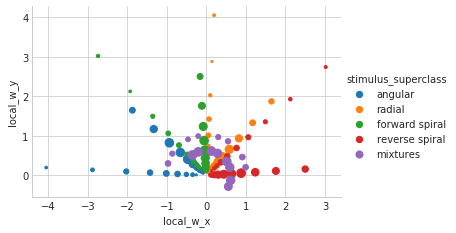

In [8]:
def scatter_sizes(x, y, s, plot_color=False, cmap=None, **kwargs):
    if plot_color:
        kwargs.pop('color')
        if cmap is None:
            cmap = 'Blues'
        plt.scatter(x, y, s=s*80, c=s, cmap=cmap, **kwargs)
    else:
        plt.scatter(x, y, s=s*80, **kwargs)

voxel_df['normalized_resp'] = voxel_df['amplitude_estimate_median'].copy()
voxel_df['normalized_resp'] = (voxel_df['normalized_resp'] - voxel_df['normalized_resp'].min()) / (voxel_df['normalized_resp'].max() - voxel_df['normalized_resp'].min())
g=sns.FacetGrid(voxel_df, size=5, aspect=1, hue='stimulus_superclass')
g.map(scatter_sizes, 'local_w_x', 'local_w_y', 'normalized_resp', plot_color=False)
g.add_legend()
scatter_ax = plt.gca()
scatter_ax.set_aspect('equal')

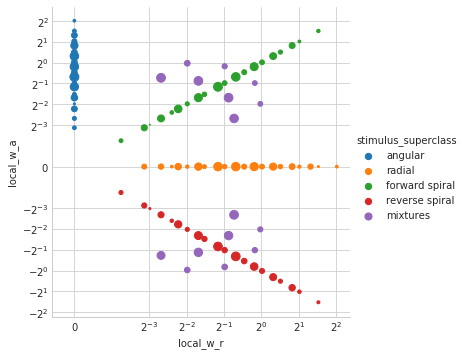

In [8]:
g=sns.FacetGrid(voxel_df, hue='stimulus_superclass', size=5, aspect=1)
g.map(scatter_sizes, 'local_w_r', 'local_w_a', 'normalized_resp')
g.add_legend()
scatter_ax = plt.gca()
scatter_ax.set_xscale('symlog', basex=2, linthreshx=2**(-3))
scatter_ax.set_yscale('symlog', basey=2, linthreshy=2**(-3))

In [270]:
import warnings
def torch_meshgrid(x, y=None):
    """from https://github.com/pytorch/pytorch/issues/7580"""
    if y is None:
        y = x
    x = torch.tensor(x, dtype=torch.float64)
    y = torch.tensor(y, dtype=torch.float64)
    m, n = x.size(0), y.size(0)
    grid_x = x[None].expand(n, m)
    grid_y = y[:, None].expand(n, m)
    return grid_x, grid_y

def _cast_as_param(x):
    return torch.nn.Parameter(torch.tensor(x, dtype=torch.float64))

class LogGaussianDonut(torch.nn.Module):
    """LogGaussianDonut in pytorch
    """
    def __init__(self, major_axis_slope, minor_axis_slope, major_axis_sigma_slope, minor_axis_sigma_slope, rotation_angle_sf_coeff=0, rotation_angle_vox_coeff=0, major_axis_intercept=0, minor_axis_intercept=0, major_axis_sigma_intercept=0, minor_axis_sigma_intercept=0, rotation_angle_intercept=0):
        super(LogGaussianDonut, self).__init__()
        self.amplitude_dict = {}
        self.major_axis_slope = _cast_as_param(major_axis_slope)
        self.major_axis_intercept = _cast_as_param(major_axis_intercept)
        self.minor_axis_slope = _cast_as_param(minor_axis_slope)
        self.minor_axis_intercept = _cast_as_param(minor_axis_intercept)
        self.major_axis_sigma_slope = _cast_as_param(major_axis_sigma_slope)
        self.major_axis_sigma_intercept = _cast_as_param(major_axis_sigma_intercept)
        self.minor_axis_sigma_slope = _cast_as_param(minor_axis_sigma_slope)
        self.minor_axis_sigma_intercept = _cast_as_param(minor_axis_sigma_intercept)
        self.rotation_angle_sf_coeff = _cast_as_param(rotation_angle_sf_coeff)
        self.rotation_angle_vox_coeff = _cast_as_param(rotation_angle_vox_coeff)
        self.rotation_angle_intercept = _cast_as_param(rotation_angle_intercept)
    
    def initialize_amplitude_dict(self, amp_dict):
        amp_dict = list(amp_dict.iteritems())
        self.amplitude_dict = dict((("%.05f"%k[0], "%.05f"%k[1]), i) for i, (k, _) in enumerate(amp_dict))
        self.amplitude_list = torch.nn.ParameterList([_cast_as_param([v]) for _, v in amp_dict])
    
    def _create_mag_angle(self, extent=(-10, 10), n_samps=1001):
        x = torch.linspace(extent[0], extent[1], n_samps)
        x, y = torch_meshgrid(x)
        r = torch.sqrt(torch.pow(x, 2) + torch.pow(y, 2))
        th = torch.atan2(y, x)
        return r, th
    
    def create_image(self, vox_ecc, vox_angle, extent=None, n_samps=1001):
        r, th = self._create_mag_angle(extent, n_samps)
        return self.evaluate(r, th, vox_ecc, vox_angle)

    def get_func_params(self, voxel_eccentricity, voxel_angle):
        amplitude = []
        try:
            ecc = [i for i in voxel_eccentricity.cpu().numpy()]
            ang = [i for i in voxel_angle.cpu().numpy()]
        except TypeError:
            ecc = [float(voxel_eccentricity.cpu().numpy())]
            ang = [float(voxel_angle.cpu().numpy())]
        for e, a in zip(ecc, ang):
            amp_idx = self.amplitude_dict[("%.05f"%e, "%.05f"%a)]
            amplitude.append(self.amplitude_list[amp_idx])
        amplitude = torch.cat(amplitude)
        major_axis = 1. / (self.major_axis_slope * voxel_eccentricity + self.major_axis_intercept)
        minor_axis = 1. / (self.minor_axis_slope * voxel_eccentricity + self.minor_axis_intercept)
        major_axis_sigma = 1. / (self.major_axis_sigma_slope * voxel_eccentricity + self.major_axis_sigma_intercept)
        minor_axis_sigma = 1. / (self.minor_axis_sigma_slope * voxel_eccentricity + self.minor_axis_sigma_intercept)
        rotation_angle_func = lambda sf_angle: self.rotation_angle_sf_coeff * sf_angle + self.rotation_angle_vox_coeff * voxel_angle + self.rotation_angle_intercept
        return amplitude, major_axis, minor_axis, major_axis_sigma, minor_axis_sigma, rotation_angle_func
    
    def evaluate(self, sf_mag, sf_angle, vox_ecc, vox_angle):
        variables = {'sf_mag': sf_mag, 'sf_angle': sf_angle, 'vox_ecc': vox_ecc, 'vox_angle': vox_angle}
        for k, v in variables.iteritems():
            if not torch.is_tensor(v):
                v = torch.tensor(v, dtype=torch.float64)
            if self.major_axis_slope.is_cuda:
                v = v.cuda()
            variables[k] = v
        amplitude, major_axis, minor_axis, major_axis_sigma, minor_axis_sigma, rotation_angle_func = self.get_func_params(variables['vox_ecc'], variables['vox_angle'])
        rotation_angle = rotation_angle_func(variables['sf_angle'])
        variables['sf_mag'] = torch.log2(variables['sf_mag'])
        variables['sf_angle'] = variables['sf_angle'] + rotation_angle
        # transform angles based on ellipse axes
        variables['sf_angle'] = torch.atan2(major_axis*torch.sin(variables['sf_angle']), minor_axis*torch.cos(variables['sf_angle']))
        # Gaussian center as function of angle
        self.ctr = torch.sqrt(torch.pow(major_axis*torch.cos(variables['sf_angle']), 2) + torch.pow(minor_axis*torch.sin(variables['sf_angle']), 2))
        # rotational sigma
        self.sigma = torch.sqrt(torch.pow(major_axis_sigma*torch.cos(variables['sf_angle']), 2) + torch.pow(minor_axis_sigma*torch.sin(variables['sf_angle']),2))
        # This is our function
        return amplitude*torch.exp(-(variables['sf_mag']-torch.log2(self.ctr))**2 / (2*self.sigma**2))

    def forward(self, spatial_frequency_magnitude, spatial_frequency_theta, voxel_eccentricity, voxel_angle):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.evaluate(spatial_frequency_magnitude, spatial_frequency_theta, voxel_eccentricity, voxel_angle)
    
    
class ConstantLogGaussianDonut(LogGaussianDonut):
    """this version does not depend on voxel eccentricity or angle at all, mainly for demo purposes"""
    def __init__(self, amplitude, major_axis, minor_axis, major_axis_sigma, minor_axis_sigma, rotation_angle):
        # This way, the {major|minor}_axis(_sigma) is what the user specifies (since we takes the inverse above)
        super(ConstantLogGaussianDonut, self).__init__(0, 0, 0, 0, 0, 0, 1./major_axis, 1./minor_axis, 1./major_axis_sigma, 1./minor_axis_sigma, rotation_angle)
        self.initialize_amplitude_dict({(0, 0): amplitude})
        
    def create_image(self, extent=None, n_samps=1001):
        r, th = self._create_mag_angle(extent, n_samps)
        return self.evaluate(r, th)
        
    def evaluate(self, sf_mag, sf_angle):
        return super(ConstantLogGaussianDonut, self).evaluate(sf_mag, sf_angle, 0, 0)
        
    def forward(self, spatial_frequency_magnitude, spatial_frequency_theta):
        return self.evaluate(spatial_frequency_magnitude, spatial_frequency_theta)

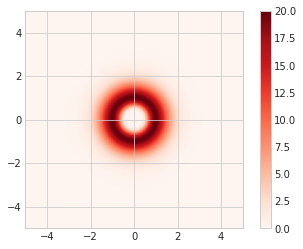

In [271]:
donut = ConstantLogGaussianDonut(20, 1, 1, .5, .5,0).to(device)
x = np.linspace(-5, 5, 1001)
xgrid, ygrid = np.meshgrid(x, x)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image((x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds')
plt.colorbar()

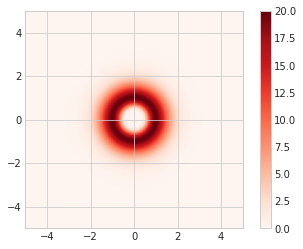

In [161]:
donut = LogGaussianDonut(1, 1, 1./.5, 1/.5, 0)
donut.initialize_amplitude_dict({(1, 0): 20})
donut.to(device)
x = np.linspace(-5, 5, 1001)
xgrid, ygrid = np.meshgrid(x, x)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image(1, 0, (x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds')
plt.colorbar()

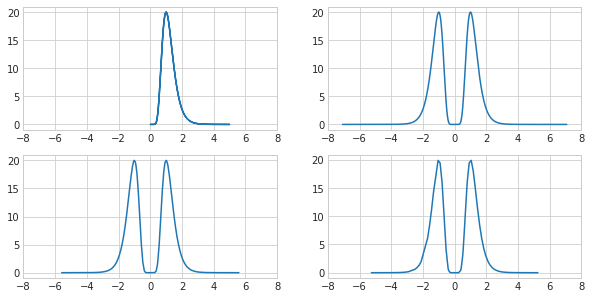

In [12]:
img = donut.create_image(1, 0, (x.min(), x.max()), len(x)).cpu().detach().numpy()
fig, axes = plt.subplots(2,2,figsize=(10, 5))
axes=axes.flatten()
R = ppt.mkR(len(x))
R *= (np.sqrt(2*x.max()**2)/R.max())
R[xgrid<0] *= -1
for ax, a in zip(axes.flatten(), [0, 1, 2, 3]):
    idx = np.where(xgrid==a*ygrid)
    r = R[idx]
    ax.plot(r, img[idx])
    ax.set(xlim=(-8, 8))

In [13]:
def create_amplitude_init_dict(df):
    df = df.groupby('voxel')[['amplitude_estimate_median', 'eccen', 'angle']].max()
    df = df.reset_index().set_index(['eccen', 'angle'])
    amp_dict = {}
    for idx, row in df.iterrows():
        amp_dict[idx] = row.amplitude_estimate_median
    return amp_dict

In [272]:
ds = FirstLevelDataset(df_path)

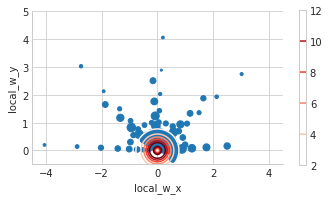

In [274]:
g=sns.FacetGrid(voxel_df, size=5, aspect=1)
g.map(scatter_sizes, 'local_w_x', 'local_w_y', 'normalized_resp')
scatter_ax = plt.gca()
scatter_ax.set_aspect('equal')

mag = torch.tensor(voxel_df.local_sf_magnitude.values, dtype=torch.float64).to(device)
direc = torch.tensor(voxel_df.local_sf_xy_direction.values, dtype=torch.float64).to(device)
ecc = torch.tensor(voxel_df.eccen.values, dtype=torch.float64).to(device)
ang = torch.tensor(voxel_df.angle.values, dtype=torch.float64).to(device)
y = torch.tensor(voxel_df.amplitude_estimate_median.values, dtype=torch.float64).to(device)

donut = LogGaussianDonut(1, 1, .2, .2)
donut.initialize_amplitude_dict(create_amplitude_init_dict(ds.df))
donut.to(device)
x = np.linspace(-3, 3, 101)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
c = scatter_ax.contour(x, x, donut.create_image(ecc[0], ang[0], (x.min(), x.max()), len(x)).detach(), cmap="Reds")
g.fig.colorbar(c, shrink=.5)
scatter_ax.set(xlim=(-4.5, 4.5), ylim=(-.5,5))
scatter_ax.set_aspect('equal')


loss_fn = torch.nn.MSELoss(False)
optimizer = torch.optim.Adam(donut.parameters(), lr=1e-3)

In [214]:
list(donut.named_parameters())

[('major_axis_slope', Parameter containing:
  tensor(1., device='cuda:0')), ('major_axis_intercept', Parameter containing:
  tensor(0., device='cuda:0')), ('minor_axis_slope', Parameter containing:
  tensor(1., device='cuda:0')), ('minor_axis_intercept', Parameter containing:
  tensor(0., device='cuda:0')), ('major_axis_sigma_slope',
  Parameter containing:
  tensor(0.2000, device='cuda:0')), ('major_axis_sigma_intercept',
  Parameter containing:
  tensor(0., device='cuda:0')), ('minor_axis_sigma_slope',
  Parameter containing:
  tensor(0.2000, device='cuda:0')), ('minor_axis_sigma_intercept',
  Parameter containing:
  tensor(0., device='cuda:0')), ('rotation_angle_sf_coeff',
  Parameter containing:
  tensor(0., device='cuda:0')), ('rotation_angle_vox_coeff',
  Parameter containing:
  tensor(0., device='cuda:0')), ('rotation_angle_intercept',
  Parameter containing:
  tensor(0., device='cuda:0')), ('amplitude_list.0', Parameter containing:
  tensor([ 4.2348], device='cuda:0')), ('ampli

In [250]:
from torch.utils import data as torchdata
class FirstLevelDataset(torchdata.Dataset):
    def __init__(self, df_path, direction_type='relative'):
        self.df = pd.read_csv(df_path)
        if direction_type not in ['relative', 'absolute']:
            raise Exception("Don't know how to handle direction_type %s!" % direction_type)
        self.direction_type = direction_type
        
    def __getitem__(self, idx):
        row = df.iloc[idx]
        if self.direction_type == 'relative':
            vals = row[['local_sf_magnitude', 'local_sf_ra_direction', 'eccen', 'angle']].values
        elif self.direction_type == 'absolute':
            vals = row[['local_sf_magnitude', 'local_sf_xy_direction', 'eccen', 'angle']].values
        feature = torch.tensor(vals.astype(float), dtype=torch.float64)
        try:
            target = torch.tensor(row['amplitude_estimate'], dtype=torch.float64)
        except KeyError:
            target = torch.tensor(row['amplitude_estimate_median'], dtype=torch.float64)
        return feature, target
            
    def __len__(self):
        return self.df.shape[0]

In [ ]:
dl = torchdata.DataLoader(ds, 50)
loss_prev = 0.01
n_epochs = 5
thresh = .00001
for t in range(n_epochs):
    for i, (features, target) in enumerate(dl):
        predictions = donut(*features.transpose(1, 0))
        loss = loss_fn(predictions, target.to(device))
        if i % 100 == 0:
            print(i, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if abs((loss - loss_prev) / loss_prev) < thresh:
            break
        loss_prev = loss
print("Final loss: %02f" % loss)

(0, 352.3548350083589)
(100, 333.54229116653175)
(200, 190.40584337907129)
(300, 77.41461135894016)
(400, 239.73361434993348)
(500, 372.89054422932054)
(600, 4.900300028064097)
(700, 13.194301047553843)
(800, 80.34109909128608)
(900, 117.07688351286293)
(1000, 30.795215161644876)
(1100, 21.512659254818114)
(1200, 261.37409447956463)
(1300, 30.972901600527372)
(1400, 148.8334422165538)
(1500, 149.28233299149204)
(1600, 227.9429255243101)
(1700, 38.32226007134452)
(1800, 145.93155608726963)
(1900, 2.6058446738608434)
(2000, 30.835011562505056)


In [74]:
list(donut.named_parameters())

[('amplitude', Parameter containing:
  tensor(13.6530, device='cuda:0')), ('major_axis', Parameter containing:
  tensor(1.0861, device='cuda:0')), ('minor_axis', Parameter containing:
  tensor(0.7122, device='cuda:0')), ('major_axis_sigma', Parameter containing:
  tensor(1.1014, device='cuda:0')), ('minor_axis_sigma', Parameter containing:
  tensor(1.2029, device='cuda:0')), ('rotation_angle', Parameter containing:
  tensor(0., device='cuda:0'))]

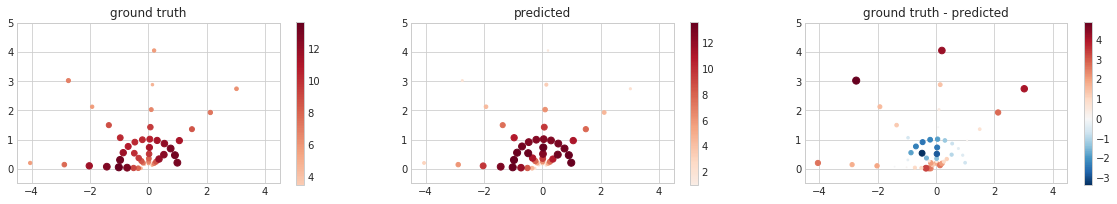

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
vals = [y.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), y.cpu().detach().numpy() - y_pred.cpu().detach().numpy()]
titles = ['ground truth', 'predicted', 'ground truth - predicted']
for ax, v, t in zip(axes.flatten(), vals, titles):
    scaled_v = (v - abs(v).min()) / (abs(v).max() - abs(v).min())
    pts=ax.scatter(voxel_df['local_w_x'], voxel_df['local_w_y'], s=abs(scaled_v)*50, c=v, cmap='RdBu_r', norm=sfp.plotting.MidpointNormalize(midpoint=0))
    ax.set_aspect('equal')
    plt.colorbar(pts, ax=ax, shrink=.6)
    ax.set(xlim=(-4.5, 4.5), ylim=(-.5, 5))
    ax.set_title(t)

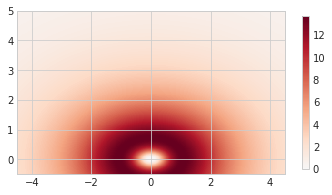

In [77]:
x = np.linspace(-8, 8, 1001)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image((x.min(), x.max())).cpu().detach(), extent=(x.min(),x.max(), x.min(), x.max()),cmap='RdBu_r', norm=sfp.plotting.MidpointNormalize(midpoint=0))
ax = plt.gca()
ax.set(xlim=(-4.5, 4.5), ylim=(-.5, 5))
plt.colorbar(shrink=.7)